# Logistic Regression Implementation

#### In this jupyter notebook, I implement two-feature logistic regression algorithm used to make predictions on whether a patient has diabetes using the dataset from: https://www.kaggle.com/datasets/kandij/diabetes-dataset. The data has 8 variables, and we can use this code to see which two variables help the sigmoid function inside the logistic regression algorithm make the best predictions, according to four metrics.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from itertools import combinations

## Import & Filter the Data

In [2]:
# Load the dataset
df = pd.read_csv("diabetes2.csv")

# Drop rows with zeros in physiologically impossible columns
features_with_invalid_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Filter out invalid rows
for feature in features_with_invalid_zeros:
    df = df[df[feature] != 0]

# Confirm size after cleaning
print("Data shape after filtering:", df.shape)

Data shape after filtering: (392, 9)


## Logistic Regression Algorithm

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y, y_pred):
    # Prevent log(0) by clipping
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def train_logistic_regression(X, y, lr=0.1, epochs=1000):
    m, n = X.shape
    # Add bias term
    X = np.hstack([np.ones((m, 1)), X])  # shape: (m, n+1)
    weights = np.zeros((n + 1,))         # shape: (n+1,)
    losses = []

    for i in range(epochs):
        z = np.dot(X, weights)           # shape: (m,)
        y_pred = sigmoid(z)              # shape: (m,)
        error = y_pred - y               # shape: (m,)
        gradient = np.dot(X.T, error) / m  # shape: (n+1,)
        weights -= lr * gradient

        if i % 100 == 0:
            loss = compute_loss(y, y_pred)
            losses.append(loss)

    return weights, losses

def predict(X, weights):
    m = X.shape[0]
    X = np.hstack([np.ones((m, 1)), X])
    preds = sigmoid(np.dot(X, weights))
    return (preds >= 0.5).astype(int)


## Results

In [4]:
# Initialize feature_columns, from which we will choose two features each time, and 
# initialize results, where we will store the results of each two feature pair's logistic regression prediction

feature_columns = [col for col in df.columns if col != 'Outcome']
results = []

The following for loop goes through every possible 2-feature combination in the feature column (28 in total, since 8C2=28). Then, it trains on 80% of the data set using the train_logistic_regression function from the algorithm above.  Finally, using the resulting weights, it predicts on the test set, recording its performance through four performance metrics: accuracy, precision, recall, and f1 score. 

The results are displayed in a table after running the cell in descending order with respect to accuracy (most accurate to least accurate pairing of two features). 

In [5]:
for f1, f2 in combinations(feature_columns, 2):
    X = df[[f1, f2]].values
    y = df['Outcome'].values

    # Normalize features (optional but improves performance)
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train logistic regression
    weights, losses = train_logistic_regression(X_train, y_train)

    # Predict
    y_pred = predict(X_test, weights)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)

    results.append({
        "Feature 1": f1,
        "Feature 2": f2,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": F1
    })

# Convert to DataFrame and print
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

# Display the top results
print(results_df.to_string(index=False))

               Feature 1                Feature 2  Accuracy  Precision   Recall  F1 Score
                     BMI                      Age  0.759494   0.833333 0.370370  0.512821
                 Glucose                      Age  0.759494   0.722222 0.481481  0.577778
             Pregnancies                  Glucose  0.746835   0.666667 0.518519  0.583333
                 Insulin                      Age  0.734177   0.800000 0.296296  0.432432
           SkinThickness                      Age  0.734177   0.687500 0.407407  0.511628
                 Glucose            SkinThickness  0.734177   0.666667 0.444444  0.533333
                 Glucose                      BMI  0.721519   0.631579 0.444444  0.521739
                     BMI DiabetesPedigreeFunction  0.721519   0.727273 0.296296  0.421053
           BloodPressure                      Age  0.721519   0.692308 0.333333  0.450000
                 Glucose DiabetesPedigreeFunction  0.721519   0.619048 0.481481  0.541667
DiabetesPe

## Analysis & Discussion

The results allow us to identify the best performing pairing according to accuracy—BMI and Age—as well as the worst performing under that same metric—Blood Pressure and Insulin. With this knowledge, we can produce plots tracking the loss function over time (as epochs increase) for the training of the logistic regression model using these opposite feature pairs. 

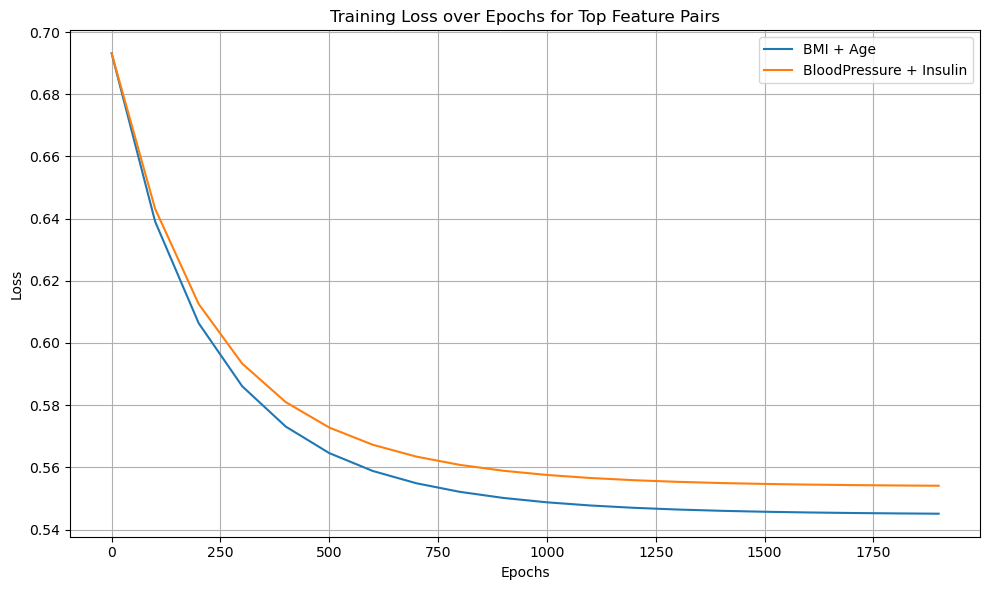

In [6]:
top_bottom_pairs = [
    ("BMI", "Age"),                  # Best-performing
    ("BloodPressure", "Insulin")     # Worst-performing
]

# Store losses
loss_dict = {}

for pair in top_bottom_pairs:
    X = df[list(pair)].values
    y = df["Outcome"].values

    # Normalize
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    weights, losses = train_logistic_regression(X_train, y_train, lr=0.01, epochs=2000)
    
    loss_dict[pair] = losses

# Plot losses
plt.figure(figsize=(10, 6))
for pair, losses in loss_dict.items():
    plt.plot(np.arange(0, len(losses)*100, 100), losses, label=f"{pair[0]} + {pair[1]}")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs for Top Feature Pairs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In the figure above, we compare the training loss over time for two different feature pairings: (BMI, Age) and (BloodPressure, Insulin). The pair (BMI, Age), which yielded the best classification accuracy, also shows a faster drop in its loss curve. In contrast, (BloodPressure, Insulin) converges more slowly, indicating that this feature combination is slightly less informative for predicting diabetes. The final loss value for (BMI, Age) is clearly lower, further supporting this idea. These trends suggest that BMI and Age contain complementary information related to diabetes risk, while BloodPressure and Insulin may be more noisy, redundant, or non-complementary in this context.

While a faster and larger total drop in the loss function is welcomed, a plateau is reached by both curves after around 1200 epochs. This indicates diminishing returns in training beyond that number of epochs, and that the model has gotten most, if not all, the useful information about the two features for predicting diabetes. Ideally, with highly predictive features, the model should plateau at a lower loss, as it captures more of useful information in the data for predicting a patient's diagnosis.

### 1D Logistic Regression

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def train_logistic_regression_1d(X, y, lr=0.01, epochs=1000):
    """
    Trains a logistic regression model with one feature.
    Returns the learned weight and bias.
    """
    m = len(X)
    w = 0.0  # weight
    b = 0.0  # bias

    for _ in range(epochs):
        z = w * X + b
        y_hat = sigmoid(z)
        error = y_hat - y

        dw = (1 / m) * np.dot(error, X)
        db = (1 / m) * np.sum(error)

        w -= lr * dw
        b -= lr * db

    return w, b

In [8]:
def plot_1d_logistic_custom(X, y, w, b, feature_name="Feature"):
    """
    Plots the sigmoid curve using learned parameters and overlays the data points.
    """
    x_vals = np.linspace(X.min() - 1, X.max() + 1, 300)
    z_vals = w * x_vals + b
    probs = sigmoid(z_vals)

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, probs, label="Sigmoid Curve", color='blue')
    plt.scatter(X, y, c=y, cmap='bwr', edgecolor='k', label="Data Points", alpha=0.7)
    plt.axhline(0.5, color='gray', linestyle='--', label='Decision Threshold')
    plt.xlabel(feature_name)
    plt.ylabel("Predicted Probability")
    plt.title(f"Custom Logistic Regression on 1D Feature: {feature_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

The single feature Logistic Regression Algorithm allows us to make plots of the logistic curve and how it grouped patients into the 'no diabetes' (blue) or 'yes diabetes' (red) categories based on it.

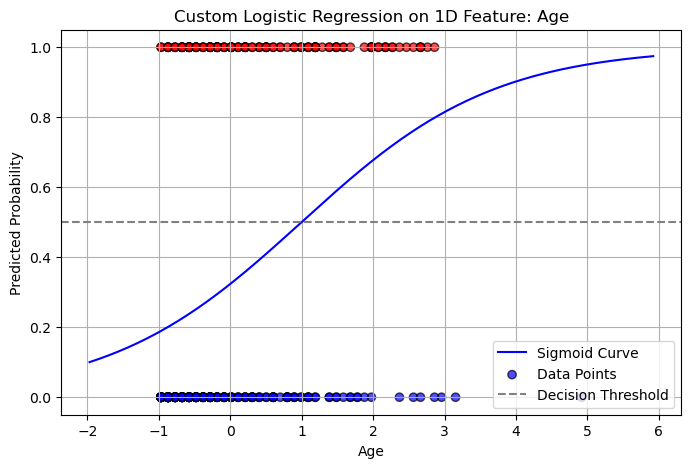

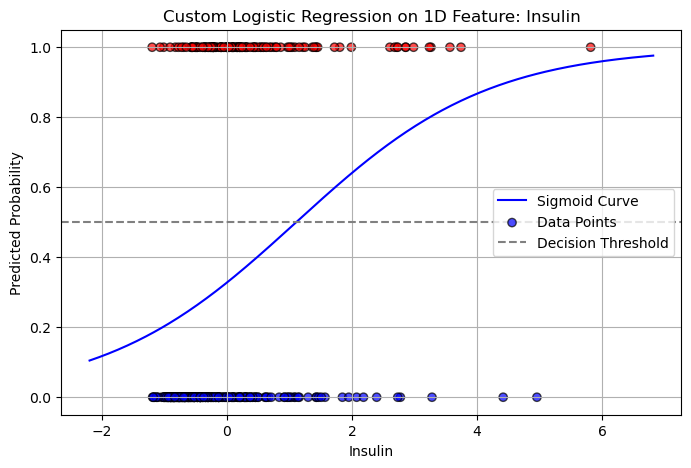

In [9]:
# Normalize feature manually
def normalize(X):
    return (X - np.mean(X)) / np.std(X)

# Choose features
features_to_test = ["Age", "Insulin"]

for feature in features_to_test:
    X_raw = df[feature].values
    y = df["Outcome"].values

    X_norm = normalize(X_raw)

    # Train logistic regression using your custom 1D trainer
    w, b = train_logistic_regression_1d(X_norm, y, lr=0.01, epochs=2000)

    # Plot using the custom function
    plot_1d_logistic_custom(X_norm, y, w, b, feature_name=feature)


The results of this 1D logistic regression show that it would not be very effective, considering the red points ('yes diabetes') and the blue points ('no diabetes') are mostly on the same side, the left side, where the sigmoid curve assigns them less probability of having diabetes. Because there is little to no difference between the 2d logistic regression's best (Age) and worst (Insuling) performing feature in the 1d case, we can assume that at least 2 variables are needed to make good predictions based on this data set.